In [1]:
%load_ext autoreload
%autoreload 2

# SequencePointcloudRegistrationPipeline

A module that implements an algorithm for optimizing the position and orientation of a vehicle in space based on a sequence of multimodal data using neural network methods.

In [2]:
import copy

from pathlib import Path
from time import time

import faiss
import numpy as np
import open3d as o3d
import open3d.core as o3c
import pandas as pd
import torch
import torchshow as ts

from hydra.utils import instantiate
from omegaconf import OmegaConf
from scipy.spatial.transform import Rotation
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm import tqdm

from geotransformer.utils.registration import compute_registration_error


from opr.datasets.itlp import ITLPCampus
from opr.pipelines.place_recognition import PlaceRecognitionPipeline
from opr.pipelines.registration import PointcloudRegistrationPipeline
from opr.pipelines.localization import LocalizationPipeline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
import os

os.environ["DISPLAY"] = ":1"

torch.cuda.synchronize()

In [4]:
def pose_to_matrix(pose):
    """From the 6D poses in the [tx ty tz qx qy qz qw] format to 4x4 pose matrices."""
    position = pose[:3]
    orientation_quat = pose[3:]
    rotation = Rotation.from_quat(orientation_quat)
    pose_matrix = np.eye(4)
    pose_matrix[:3,:3] = rotation.as_matrix()
    pose_matrix[:3,3] = position
    return pose_matrix


# def compute_error(estimated_pose, gt_pose):
#     """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
#     estimated_pose = pose_to_matrix(estimated_pose)
#     gt_pose = pose_to_matrix(gt_pose)
#     return compute_registration_error(estimated_pose, gt_pose)

def compute_error(estimated_pose, gt_pose):
    """For the 6D poses in the [tx ty tz qx qy qz qw] format."""
    estimated_pose = pose_to_matrix(estimated_pose)
    gt_pose = pose_to_matrix(gt_pose)
    error_pose = np.linalg.inv(estimated_pose) @ gt_pose
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = Rotation.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / np.pi
    angle_error = abs(90 - abs(angle_error-90))
    return angle_error, dist_error


def draw_pc(pc: Tensor, color: str = "blue"):
    pc_o3d = o3c.Tensor.from_dlpack(torch.utils.dlpack.to_dlpack(pc))
    pcd = o3d.t.geometry.PointCloud(pc_o3d)
    if color == "blue":
        c = [0.0, 0.0, 1.0]
    elif color == "red":
        c = [1.0, 0.0, 0.0]
    else:
        c = [0.0, 1.0, 0.0]
    pcd = pcd.paint_uniform_color(c)
    o3d.visualization.draw_geometries(
        [pcd.to_legacy()],
    )


def invert_rigid_transformation_matrix(T: np.ndarray) -> np.ndarray:
    """
    Inverts a 4x4 rigid body transformation matrix.

    Args:
        T (np.ndarray): A 4x4 rigid body transformation matrix.

    Returns:
        np.ndarray: The inverted 4x4 rigid body transformation matrix.
    """
    assert T.shape == (4, 4), "Input matrix must be 4x4."

    R = T[:3, :3]
    t = T[:3, 3]

    R_inv = R.T
    t_inv = -R.T @ t

    T_inv = np.eye(4)
    T_inv[:3, :3] = R_inv
    T_inv[:3, 3] = t_inv

    return T_inv


def draw_pc_pair(
    pc_blue: Tensor, pc_blue_pose: np.ndarray | Tensor, pc_red: Tensor, pc_red_pose: np.ndarray | Tensor
):
    pc_blue_o3d = o3c.Tensor.from_dlpack(torch.utils.dlpack.to_dlpack(copy.deepcopy(pc_blue)))
    pc_red_o3d = o3c.Tensor.from_dlpack(torch.utils.dlpack.to_dlpack(copy.deepcopy(pc_red)))

    blue_pcd = o3d.t.geometry.PointCloud(pc_blue_o3d)
    blue_pcd_tmp = copy.deepcopy(blue_pcd)

    red_pcd = o3d.t.geometry.PointCloud(pc_red_o3d)
    red_pcd_tmp = copy.deepcopy(red_pcd)

    blue_pcd_tmp.voxel_down_sample(voxel_size=0.3)
    # blue_pcd_tmp.transform(pose_to_matrix(pc_blue_pose))
    blue_pcd_tmp = blue_pcd_tmp.paint_uniform_color([0.0, 0.0, 1.0])

    red_pcd_tmp.voxel_down_sample(voxel_size=0.3)
    red_pcd_tmp.transform(pose_to_matrix(pc_red_pose))
    red_pcd_tmp.transform(invert_rigid_transformation_matrix(pose_to_matrix(pc_blue_pose)))
    red_pcd_tmp = red_pcd_tmp.paint_uniform_color([1.0, 0.0, 0.0])
    o3d.visualization.draw_geometries(
        [blue_pcd_tmp.to_legacy(), red_pcd_tmp.to_legacy()],
    )


You can **download the dataset**:

- Kaggle:
  - [ITLP Campus Outdoor](https://www.kaggle.com/datasets/alexandermelekhin/itlp-campus-outdoor)
- Hugging Face:
  - [ITLP Campus Outdoor](https://huggingface.co/datasets/OPR-Project/ITLP-Campus-Outdoor)

To **download the model weights**, run the following command:

```bash
# place recognition weights
wget -O ../../weights/place_recognition/multi-image_lidar_late-fusion_itlp-finetune.pth https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/multi-image_lidar_late-fusion_itlp-finetune.pth

# registration weights
wget -O ../../weights/registration/hregnet_nuscenes.pth https://huggingface.co/OPR-Project/Registration-nuScenes/resolve/main/hregnet_nuscenes.pth
```


In [5]:
# place recognition weights
!wget -O ../../weights/place_recognition/multi-image_lidar_late-fusion_itlp-finetune.pth https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/multi-image_lidar_late-fusion_itlp-finetune.pth

# registration weights
!wget -O ../../weights/registration/hregnet_nuscenes.pth https://huggingface.co/OPR-Project/Registration-nuScenes/resolve/main/hregnet_nuscenes.pth

--2025-05-06 15:16:48--  https://huggingface.co/OPR-Project/PlaceRecognition-NCLT/resolve/main/multi-image_lidar_late-fusion_itlp-finetune.pth
Resolving huggingface.co (huggingface.co)... 3.165.190.15, 3.165.190.87, 3.165.190.31, ...
Connecting to huggingface.co (huggingface.co)|3.165.190.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/e8/30/e8306844a097b119f688c0cfcf564a9f584f52c28b0d3c5b11e560cb0c3e7eeb/81405a81126d61fa3e1eb7482da045debb934d10b2b455ad47bdf51776584497?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27multi-image_lidar_late-fusion_itlp-finetune.pth%3B+filename%3D%22multi-image_lidar_late-fusion_itlp-finetune.pth%22%3B&Expires=1746548209&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NjU0ODIwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2U4LzMwL2U4MzA2ODQ0YTA5N2IxMTlmNjg4YzBjZmNmNTY0YTlmNTg0ZjUyYzI4YjBkM2M1YjExZTU2MGNiMGMzZTdlZWIv

In [6]:
DATASET_ROOT = "/home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor"

TRACK_LIST = [
    "00_2023-02-10",
    "03_2023-04-11",
    "05_2023-08-15-day",
    "07_2023-10-04-day",
]

SEASON_MAPPING = {
    "00_2023-02-10": "winter",
    "03_2023-04-11": "spring",
    "05_2023-08-15-day": "summer",
    "07_2023-10-04-day": "fall",
}

print("Test track list:")
print(TRACK_LIST)

Test track list:
['00_2023-02-10', '03_2023-04-11', '05_2023-08-15-day', '07_2023-10-04-day']


In [7]:
SENSOR_SUITE = ["front_cam", "back_cam", "lidar"]

BATCH_SIZE = 4
NUM_WORKERS = 4
DEVICE = "cuda"

PR_MODEL_CONFIG_PATH = "../../configs/model/place_recognition/multi-image_lidar_late-fusion.yaml"
PR_WEIGHTS_PATH = "../../weights/place_recognition/multi-image_lidar_late-fusion_itlp-finetune.pth"

REGISTRATION_MODEL_CONFIG_PATH = "../../configs/model/registration/hregnet.yaml"
REGISTRATION_WEIGHTS_PATH = "../../weights/registration/hregnet_nuscenes.pth"

## Init models

In [8]:
pr_model_config = OmegaConf.load(PR_MODEL_CONFIG_PATH)
pr_model = instantiate(pr_model_config)
pr_model.load_state_dict(torch.load(PR_WEIGHTS_PATH))
pr_model = pr_model.to(DEVICE)
pr_model.eval();

reg_model_config = OmegaConf.load(REGISTRATION_MODEL_CONFIG_PATH)
reg_model = instantiate(reg_model_config)
reg_model.load_state_dict(torch.load(REGISTRATION_WEIGHTS_PATH))
reg_model = reg_model.to(DEVICE)
reg_model.eval();

2025-05-06 15:17:03.584 | WARNING  | opr.models.place_recognition.pointmamba:<module>:16 - The 'pointmamba' package is not installed. Please install it manually if neccessary.


## Calculate descriptors for databases

In [9]:
dataset = ITLPCampus(
    dataset_root=DATASET_ROOT,
    subset="test",
    csv_file="full_test.csv",
    sensors=SENSOR_SUITE,
)
dataset.dataset_df = dataset.dataset_df[dataset.dataset_df["track"].isin(TRACK_LIST)]
dataset.dataset_df.reset_index(inplace=True)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=dataset.collate_fn,
)


In [10]:
descriptors = []
with torch.no_grad():
    for batch in tqdm(dataloader):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        final_descriptor = pr_model(batch)["final_descriptor"]
        descriptors.append(final_descriptor.detach().cpu().numpy())

descriptors = np.concatenate(descriptors, axis=0)

100%|██████████| 145/145 [00:04<00:00, 29.73it/s]


### Saving database indexes

In [11]:
dataset_df = dataset.dataset_df

for track, indices in dataset_df.groupby("track").groups.items():
    track_descriptors = descriptors[indices]
    track_index = faiss.IndexFlatL2(track_descriptors.shape[1])
    track_index.add(track_descriptors)
    faiss.write_index(track_index, f"{DATASET_ROOT}/{track}/index.faiss")
    print(f"Saved index {DATASET_ROOT}/{track}/index.faiss")


Saved index /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/00_2023-02-10/index.faiss
Saved index /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/03_2023-04-11/index.faiss
Saved index /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/05_2023-08-15-day/index.faiss
Saved index /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/07_2023-10-04-day/index.faiss


### Removing old pre-computed registration features

When using the `precomputed_reg_feats=True` option, the pipeline will use the pre-computed registration features. If you want to re-compute them, you need to remove the old ones first (if they exist). You can do this by running the following command:


In [13]:
import shutil

for track in TRACK_LIST:
    reg_model_name = "HRegNet"
    reg_features_dir = Path(f"{DATASET_ROOT}/{track}/{reg_model_name}_features")
    if reg_features_dir.exists():
        print(f"Removing existing registration features directory: {reg_features_dir}")
        shutil.rmtree(reg_features_dir)
        print(f"Successfully removed {reg_features_dir}")
    else:
        print(f"No existing registration features directory found at {reg_features_dir}")

Removing existing registration features directory: /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/00_2023-02-10/HRegNet_features
Successfully removed /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/00_2023-02-10/HRegNet_features
Removing existing registration features directory: /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/03_2023-04-11/HRegNet_features
Successfully removed /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/03_2023-04-11/HRegNet_features
Removing existing registration features directory: /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/05_2023-08-15-day/HRegNet_features
Successfully removed /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/05_2023-08-15-day/HRegNet_features
Removing existing registration features directory: /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/07_2023-10-04-day/HRegNet_features
Successfully removed /home/docker_o

## Test

In [14]:
RECALL_THRESHOLD = 25.0

all_pr_recalls = {}
all_reg_recalls = {}  # it is recall after registration (if estimated pose within RECALL_THRESHOLD), do not confuse with registration recall

all_mean_pr_rotation_errors = {}
all_mean_pr_translation_errors = {}

all_median_pr_rotation_errors = {}
all_median_pr_translation_errors = {}

all_mean_reg_rotation_errors = {}
all_mean_reg_translation_errors = {}

all_median_reg_rotation_errors = {}
all_median_reg_translation_errors = {}

all_times = []

correct_examples = []  # the most representative correct pairs
pr_incorrect_examples = []  # the most representative incorrect pairs where place recognition failed
reg_incorrect_examples = []  # the most representative incorrect pairs where registration failed

for db_track in TRACK_LIST:
    pr_pipe = PlaceRecognitionPipeline(
        database_dir=Path(DATASET_ROOT) / db_track,
        model=pr_model,
        model_weights_path=PR_WEIGHTS_PATH,
        device=DEVICE,
    )
    for query_track in TRACK_LIST:
        if db_track == query_track:
            continue

        reg_pipe = PointcloudRegistrationPipeline(
            model=reg_model,
            model_weights_path=REGISTRATION_WEIGHTS_PATH,
            device=DEVICE,
            voxel_downsample_size=0.3,
            num_points_downsample=8192,
        )
        loc_pipe = LocalizationPipeline(
            place_recognition_pipeline=pr_pipe,
            registration_pipeline=reg_pipe,
            precomputed_reg_feats=True,
            pointclouds_subdir="lidar",
        )

        query_dataset = copy.deepcopy(dataset)
        query_dataset.dataset_df = query_dataset.dataset_df[query_dataset.dataset_df["track"] == query_track].reset_index(drop=True)
        query_df = query_dataset.dataset_df

        db_dataset = copy.deepcopy(dataset)
        db_dataset.dataset_df = db_dataset.dataset_df[db_dataset.dataset_df["track"] == db_track].reset_index(drop=True)
        db_df = db_dataset.dataset_df

        loc_pipe.pr_pipe.database_df = db_df
        loc_pipe.database_df = db_df


        pr_matches = []
        pr_rotation_errors = []
        pr_translation_errors = []

        reg_matches = []
        reg_rotation_errors = []
        reg_translation_errors = []

        times = []

        for q_i, query in tqdm(enumerate(query_dataset)):
            query_pose = query_df.iloc[q_i][["tx", "ty", "tz", "qx", "qy", "qz", "qw"]].to_numpy()

            t = time()
            output = loc_pipe.infer(query)
            torch.cuda.current_stream().synchronize()
            times.append(time() - t)

            pr_rotation_error, pr_translation_error = compute_error(output["db_match_pose"], query_pose)
            reg_rotation_error, reg_translation_error = compute_error(output["estimated_pose"], query_pose)

            pr_correct = pr_translation_error < RECALL_THRESHOLD
            reg_correct = reg_translation_error < RECALL_THRESHOLD

            pr_matches.append(pr_correct)
            pr_rotation_errors.append(pr_rotation_error)
            pr_translation_errors.append(pr_translation_error)

            reg_matches.append(reg_correct)
            reg_rotation_errors.append(reg_rotation_error)
            reg_translation_errors.append(reg_translation_error)

            if pr_correct and reg_correct \
                and reg_rotation_error < pr_rotation_error and reg_translation_error < pr_translation_error \
                and reg_rotation_error < 3.0 and reg_translation_error < 1.0:
                query["pose"] = query_pose
                db_match = db_dataset[output["db_match_idx"]]
                db_match["pose"] = output["db_match_pose"]
                correct_examples.append((query, db_match, output["estimated_pose"]))

            if pr_correct and not reg_correct:
                query["pose"] = query_pose
                db_match = db_dataset[output["db_match_idx"]]
                db_match["pose"] = output["db_match_pose"]
                reg_incorrect_examples.append((query, db_match, output["estimated_pose"]))

            if not pr_correct and pr_translation_error > 50.0:
                query["pose"] = query_pose
                db_match = db_dataset[output["db_match_idx"]]
                db_match["pose"] = output["db_match_pose"]
                pr_incorrect_examples.append((query, db_match, output["estimated_pose"]))

        key_str = f"DB {SEASON_MAPPING[db_track]}, Query {SEASON_MAPPING[query_track]}"

        all_pr_recalls[key_str] = np.mean(pr_matches)
        all_reg_recalls[key_str] = np.mean(reg_matches)

        all_mean_pr_rotation_errors[key_str] = np.mean(pr_rotation_errors)
        all_mean_pr_translation_errors[key_str] = np.mean(pr_translation_errors)
        all_median_pr_rotation_errors[key_str] = np.median(pr_rotation_errors)
        all_median_pr_translation_errors[key_str] = np.median(pr_translation_errors)

        all_mean_reg_rotation_errors[key_str] = np.mean(reg_rotation_errors)
        all_mean_reg_translation_errors[key_str] = np.mean(reg_translation_errors)
        all_median_reg_rotation_errors[key_str] = np.median(reg_rotation_errors)
        all_median_reg_translation_errors[key_str] = np.median(reg_translation_errors)
        all_times.extend(times[1:]) # drop the first iteration cause it is always slower

2025-05-06 15:47:35.079 | WARNING  | opr.pipelines.localization.base:_setup_precomputed_reg_feats:95 - Precomputed registration features directory not found: /home/docker_opr/Datasets/OpenPlaceRecognition/itlp_campus_outdoor/00_2023-02-10/HRegNet_features. It will be created and features will be computed.
2025-05-06 15:47:35.080 | WARNING  | opr.pipelines.localization.base:_setup_precomputed_reg_feats:105 - Precomputed registration features directory is empty. Computing features.
  0%|          | 0/609 [00:00<?, ?it/s]2025-05-06 15:47:35.080 | WARNING  | opr.pipelines.localization.base:_setup_precomputed_reg_feats:105 - Precomputed registration features directory is empty. Computing features.
136it [00:19,  6.94it/s]                         
152it [00:21,  7.04it/s]
152it [00:21,  7.01it/s]
2025-05-06 15:48:54.391 | WARNING  | opr.pipelines.localization.base:_setup_precomputed_reg_feats:95 - Precomputed registration features directory not found: /home/docker_opr/Datasets/OpenPlaceRecog

In [15]:
len(correct_examples), len(pr_incorrect_examples), len(reg_incorrect_examples)

(205, 26, 3)

In [16]:
print("Recall@1:")
for key, value in all_reg_recalls.items():
    print(f"{key}: {value*100:.2f}")

print(f"Mean: {np.mean(list(all_reg_recalls.values()))*100:.2f}")

Recall@1:
DB winter, Query spring: 100.00
DB winter, Query summer: 92.11
DB winter, Query fall: 98.68
DB spring, Query winter: 100.00
DB spring, Query summer: 96.71
DB spring, Query fall: 98.68
DB summer, Query winter: 94.96
DB summer, Query spring: 93.38
DB summer, Query fall: 100.00
DB fall, Query winter: 97.12
DB fall, Query spring: 94.85
DB fall, Query summer: 100.00
Mean: 97.21


In [17]:
print("Median RRE:")
for key, value in all_median_reg_rotation_errors.items():
    print(f"{key}: {value:.2f}")

print(f"Mean: {np.mean(list(all_median_reg_rotation_errors.values())):.2f}")

Median RRE:
DB winter, Query spring: 1.01
DB winter, Query summer: 7.07
DB winter, Query fall: 3.99
DB spring, Query winter: 0.91
DB spring, Query summer: 5.65
DB spring, Query fall: 3.89
DB summer, Query winter: 6.75
DB summer, Query spring: 5.18
DB summer, Query fall: 4.38
DB fall, Query winter: 3.82
DB fall, Query spring: 4.27
DB fall, Query summer: 4.12
Mean: 4.25


In [18]:
print("Median RTE:")
for key, value in all_median_reg_translation_errors.items():
    print(f"{key}: {value:.2f}")

print(f"Mean: {np.mean(list(all_median_reg_translation_errors.values())):.2f}")

Median RTE:
DB winter, Query spring: 0.31
DB winter, Query summer: 4.39
DB winter, Query fall: 4.04
DB spring, Query winter: 0.31
DB spring, Query summer: 3.17
DB spring, Query fall: 4.15
DB summer, Query winter: 3.35
DB summer, Query spring: 3.49
DB summer, Query fall: 2.80
DB fall, Query winter: 4.07
DB fall, Query spring: 4.39
DB fall, Query summer: 2.75
Mean: 3.10


In [19]:
print(f"Mean registration inference time: {np.mean(loc_pipe.reg_pipe.stats_history['total_time']) * 1000:.2f} ms")

Mean registration inference time: 55.38 ms


PR pose error: (12.19145317656897, 3.472897046660842)
REG pose error: (1.6389829599811492, 0.38131849402681156)


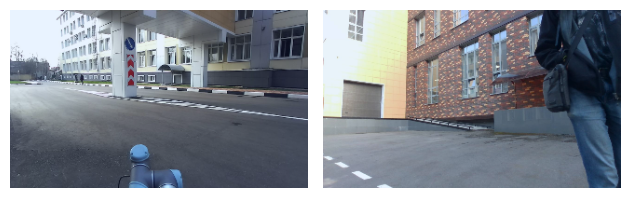

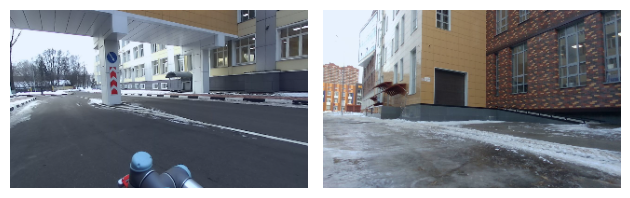

In [20]:
correct_example = correct_examples[0]

query_sample, db_match_sample, estimated_pose = correct_example

# draw_pc_pair(
#     query_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"],
#     db_match_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"]
# )

# draw_pc_pair(
#     query_sample["pointcloud_lidar_coords"],
#     estimated_pose,
#     db_match_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"]
# )

ts.show([
    query_sample["image_front_cam"], query_sample["image_back_cam"],
])
ts.show([
    db_match_sample["image_front_cam"], db_match_sample["image_back_cam"],
])
print(f"PR pose error: {compute_error(db_match_sample['pose'], query_sample['pose'])}")
print(f"REG pose error: {compute_error(estimated_pose, query_sample['pose'])}")

PR pose error: (6.859939738193518, 24.40212794501121)
REG pose error: (43.343753469661, 27.234603086826542)


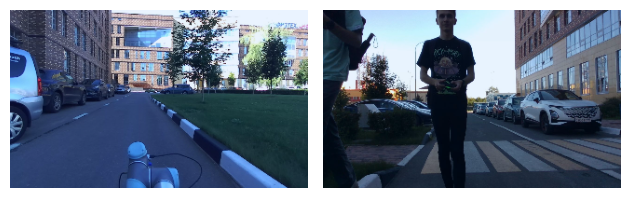

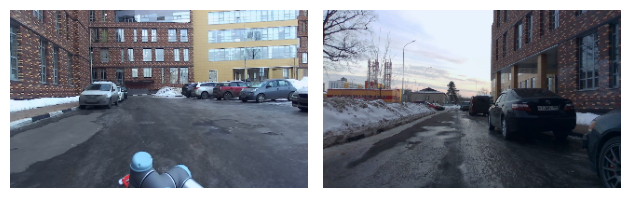

In [21]:
reg_incorrect_example = reg_incorrect_examples[0]

query_sample, db_match_sample, estimated_pose = reg_incorrect_example

# draw_pc_pair(
#     query_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"],
#     db_match_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"]
# )

# draw_pc_pair(
#     query_sample["pointcloud_lidar_coords"],
#     estimated_pose,
#     db_match_sample["pointcloud_lidar_coords"],
#     db_match_sample["pose"]
# )

ts.show([
    query_sample["image_front_cam"], query_sample["image_back_cam"],
])
ts.show([
    db_match_sample["image_front_cam"], db_match_sample["image_back_cam"],
])
print(f"PR pose error: {compute_error(db_match_sample['pose'], query_sample['pose'])}")
print(f"REG pose error: {compute_error(estimated_pose, query_sample['pose'])}")